In [85]:
from astropy.time import Time
import datetime as dt
import astropy.units as u
import warnings
from astropy.utils.exceptions import AstropyUserWarning, AstropyWarning
from astropy.table import vstack, Table
import numpy as np
from transit_prediction.utils.list_of_constraints import List_of_constraints 

# Import astroplan tools and constraints
# Other constraints are available
from astroplan import (FixedTarget, Observer, EclipsingSystem,
                       PrimaryEclipseConstraint, is_event_observable,
                       AtNightConstraint, AltitudeConstraint,
                       LocalTimeConstraint, AirmassConstraint)

from masterfile import MasterFile

# Get planets infos

In [703]:
# target_list = ['51 Peg', 'ups And b']  # Stefan

# target_list = ['WASP-52', 'K2-232']  # Anne

target_list = ["MASCARA-1", "KELT-20", "KELT-9"]

# target_list = ["GJ 436 b",
#                "GJ 1214 b",
#                "GJ 3470 b",
#                "K2-25 b",
#                "HD 189733 b",
#                "WASP-69 b",
#                "HAT-P-1 b",
#                "WASP-80 b",
#                "WASP-107 b"]


# target_list = [
# #     ------------
# #     Hot Jupiters  -  20
# #     ------------ 
#     'HD 189733 b',
#     'WASP-76 b',
#     'WASP-121 b',
#     'KELT-4 A b',
#     'WASP-74 b',
#     'HAT-P-30 b',
#     'KELT-14 b',
#     'WASP-85 A b',
#     'WASP-77 A b',
#     'WASP-82 b',
#     'WASP-140 b',
#     'WASP-95 b',
#     'K2-31 b',
#     'WASP-97 b',
#     'MASCARA-1 b',
#     'HAT-P-49 b',
#     'WASP-71 b',
#     'WASP-14 b',
#     'WASP-18 b',
#     'HAT-P-20 b', 
# #     -------------
# #     Warm Jupiters  -  26
# #     ------------- 
#     'HD 209458 b',
#     'KELT-8 b',
#     'WASP-54 b',
#     'WASP-79 b',
#     'KELT-10 b',
#     'WASP-35 b',
#     'KELT-17 b',
#     'WASP-34 b',
#     'WASP-7 b',
#     'NGTS-2 b',
#     'XO-1 b',
#     'WASP-41 b',
#     'WASP-70 A b',
#     'WASP-84 b',
#     'KELT-15 b',
#     'WASP-16 b',
#     'WASP-68 b',
#     'WASP-8 b',
#     'WASP-136 b',
#     'WASP-38 b',
#     'WASP-130 b',
#     'WASP-99 b',
#     'WASP-73 b',
#     'WASP-120 b',
#     'HAT-P-34 b',
#     'EPIC 246851721 b',
# #     -------------
# #     Warm Neptunes  -  27
# #     ------------- 
#     'KELT-11 b',
#     'WASP-127 b',
#     'WASP-107 b',
#     'WASP-69 b',
#     'GJ 436 b',
#     'WASP-20 b',
#     'WASP-94 A b',
#     'WASP-101 b',
#     'WASP-131 b',
#     'WASP-80 b',
#     'GJ 3470 b',
#     'WASP-117 b',
#     'K2-232 b',
#     'WASP-126 b',
#     'WASP-62 b',
#     'WASP-49 b',
#     'HAT-P-26 b',
#     'WASP-29 b',
#     'WASP-63 b',
#     'WASP-118 b',
#     'HD 89345 b',
#     'WASP-132 b',
#     'WASP-156 b',
#     'K2-287 b',
#     'K2-261 b',
#     'K2-132 b',
#     'HD 119130 b',
# #     ------------------
# #     Warm mini-Neptunes  -  6
# #     ------------------ 
#     'pi Men c',
#     'HD 97658 b',
#     'GJ 9827 d',
#     'K2-266 d',
#     'K2-266 e',
#     'HIP 116454 b', 
#     'TRAPPIST-1 b',
#     'TRAPPIST-1 c',
#     'TRAPPIST-1 d',
#     'TRAPPIST-1 e',
#     'TRAPPIST-1 f',
#     'TRAPPIST-1 g',
#     'TRAPPIST-1 h']

In [704]:
data = MasterFile.read().by_plName(*target_list)

# Inputs

In [705]:
t1, t2 = Time(['2019-08-01 00:00', '2020-01-31 00:00'])
site = 'cfht'

# t1, t2 = Time(['2020-01-01 00:00','2025-01-01 00:00'])  # NIRPS
# site = 'LaSilla'  # NIRPS

abs_baseline = 30 * u.min
baseline = None #2
# See astroplan available constraints
constraints = [AtNightConstraint.twilight_nautical(),
               AirmassConstraint(max=2.5)
              ]
constraints_list = List_of_constraints(constraints)
supp_cols = ['st_j','st_h']
n_eclipses = 5000

## Test if all required infos are there

In [684]:
required_info = data['pl_name',
                     'pl_tranmid',#'pl_tranmiderr1','pl_tranmiderr2',
                     'pl_orbper',
                     'pl_trandur']

In [685]:
# def check_infos(masterfile, target_list, interactive=True
#                 infos=['pl_tranmid', 'pl_orbper', 'pl_trandur']):
    
    

In [686]:
print('Add missing infos with MasterFile.insert_value()!!')
required_info.show_in_notebook(display_length=10)

Add missing infos with MasterFile.insert_value()!!


idx,pl_name,pl_tranmid,pl_orbper,pl_trandur
,,d,d,d
0,HD 189733 b,2453955.5255511,2.21857567,0.07515
1,WASP-76 b,2456107.85507,1.809886,0.1539
2,WASP-121 b,2456635.70832,1.2749255,0.1203
3,KELT-4 A b,2456190.30201,2.9895932,0.14428
4,WASP-74 b,2456506.8918,2.13775,0.09541666666666666
5,HAT-P-30 b,2455456.4662,2.8106,0.0887
6,KELT-14 b,2456665.22401,1.7100566,0.09117
7,WASP-85 A b,2456847.472856,2.6556777,0.10816
8,WASP-77 A b,2455870.44977,1.36003,0.09


## Define some quantities

In [687]:
# Define needed quantities based on planets infos
# Must be quatities arrays (astropy)
# Here we use a given astropy Table (data) to get the infos

epoch, period, transit_duration = data.cols_2_qarr('pl_tranmid','pl_orbper','pl_trandur')
epoch = Time(epoch, format='jd')
pl_name = data['pl_name']


observing_time = t1
obs = Observer.at_site(site)

# Compute events

In [688]:
col_names = ('pl_name',
             'mid_tr',
             'AM_mid_tr',
             'tr_start',
             'tr_end',
             'AM_tr_start',
             'AM_tr_end',
             'start',
             'end',
             'AM_start',
             'AM_end',
             'Obs_start',
             'Baseline_before',
             'Obs_end',
             'Baseline_after',
             'moon',
             *supp_cols
            )
meta = {'Time_limits': [t1, t2],
        'Target_list': pl_name.tolist(),
        'Site': site,
        'Baseline': baseline,
        'Abs_baseline': abs_baseline,
        **constraints_list.show()
       }

In [689]:
from astropy.coordinates.name_resolve import NameResolveError
from astropy.coordinates import SkyCoord

In [690]:
full_table = Table()
for itar in range(len(pl_name)):

    # -------------------------
    # Steps to predict transits
    # -------------------------
    try:
        target = FixedTarget.from_name(pl_name[itar])
    except NameResolveError as e:
        print(e)
        try_name = ' '.join(pl_name[itar].split(' ')[:-2])
        print("Trying with {}".format(try_name))
        try:
            target = FixedTarget.from_name(try_name)
        except NameResolveError as e:
            print(e)
            print('Searching in masterfile for RA and dec')
            try_radec = MasterFile.read().by_plName(pl_name[itar])
            ra = try_radec['ra'].quantity
            dec = try_radec['dec'].quantity
            coord = SkyCoord(ra=ra, dec=dec)
            target = FixedTarget(coord=coord,
                                 name=pl_name[itar])

    sys = EclipsingSystem(primary_eclipse_time=epoch[itar],
                          orbital_period=period[itar],
                          duration=transit_duration[itar],
                          name=target.name
                         )
    if abs_baseline is not None:
        sys_baseline = EclipsingSystem(primary_eclipse_time=epoch[itar],
                                   orbital_period=period[itar],
                                   duration=2*abs_baseline
                                       +transit_duration[itar],
                                   name=target.name
                                  )
    elif baseline is not None:
        sys_baseline = EclipsingSystem(primary_eclipse_time=epoch[itar],
                                   orbital_period=period[itar],
                                   duration=baseline*transit_duration[itar],
                                   name=target.name
                                  )

    t_mid = sys.next_primary_eclipse_time(observing_time, n_eclipses=n_eclipses)
#     t_mid = sys.next_secondary_eclipse_time(observing_time, n_eclipses=n_eclipses)


    
    if t_mid[-1] < t2:
        warnings.warn('end time ('+t2.value +
                      ') is passed the last computed event time (' +
                      t_mid[-1].value+')\n' +
                     '\t You can change the n_eclipse kwarg ' +
                     'value or choose a different window (start or end time)',
                     AstropyUserWarning
                    )

    # You can skip this step by addind a time constraint in the list of constraints
    t_mid = t_mid[t_mid < t2]

    n_event, = t_mid.shape

    t_baseline = sys_baseline.next_primary_ingress_egress_time(observing_time, n_eclipses=n_event)
#     t_baseline = sys_baseline.next_secondary_ingress_egress_time(observing_time, n_eclipses=n_event)

    t1_t4 = sys.next_primary_ingress_egress_time(observing_time, n_eclipses=n_event)
#     t1_t4 = sys.next_secondary_ingress_egress_time(observing_time, n_eclipses=n_event)
    
    index = is_event_observable(constraints_list, obs, target,
                                times_ingress_egress=t_baseline).squeeze()

    # -------------------
    # End of steps to predict transits
    # -------------------

    # Put the infos in a table and stack it to the full table
    if index.any():
        name = np.repeat(sys.name,index.sum()).astype(str)
        moon = obs.moon_illumination(t_mid[index])
        AM_mid = obs.altaz(t_mid[index], target).secz
        AM_t1_t4 = obs.altaz(t1_t4[index], target).secz
        AM_base = obs.altaz(t_baseline[index], target).secz
        obs_start = min_start_times(constraints_list, obs, target, t_mid[index])
        baseline_before = (t1_t4[index][:,0] - obs_start).to('min')
        obs_end = max_end_times(constraints_list, obs, target, t_mid[index])
        baseline_after = (obs_end - t1_t4[index][:,1]).to('min')
        supp = [np.repeat(data[key][itar],index.sum())
                for key in supp_cols]
        cols = [name,
                t_mid[index].iso,
                AM_mid,
                *t1_t4[index].T.iso,
                *AM_t1_t4.T,
                *t_baseline[index].T.iso,
                *AM_base.T,
                obs_start.iso,
                baseline_before,
                obs_end.iso,
                baseline_after,
                moon,
                *supp
               ]
        table_sys = Table(cols, names=col_names, masked=True)
        full_table = vstack([table_sys, full_table])
    else:
        warnings.warn('No event found for '+sys.name, AstropyUserWarning)

if full_table:
    full_table.sort('mid_tr')
    full_table.meta = meta
else:
    warnings.warn('No event found at all', AstropyUserWarning)

Unable to find coordinates for name 'WASP-85 A b'
Trying with WASP-85


Unable to find coordinates for name 'NGTS-2 b'
Trying with 
Unable to find coordinates for name ''
Searching in masterfile for RA and dec


Unable to find coordinates for name 'WASP-70 A b'
Trying with WASP-70


Unable to find coordinates for name 'K2-287 b'
Trying with 
Unable to find coordinates for name ''
Searching in masterfile for RA and dec


## Save file

In [692]:
# full_table.write('list_of_transits.ecsv', delimiter=',')
full_table.write('/home/adb/NIRPS/list_of_transits.ecsv', delimiter=',')
# full_table.write('/home/adb/Doctorat/transit_predictions/list_of_transits_Boucher.ecsv',
#                  delimiter=',', overwrite=True)

In [ ]:
full_table

In [243]:
time_mid = Time(full_table['mid_tr'][0])
target = FixedTarget.from_name(pl_name[0])


In [287]:
min_start_times(constraints_list, obs, target, [time_mid])

<Time object: scale='utc' format='jd' value=[2458708.73795266]>

In [259]:
obs.sun_set_time(time_mid, which='previous').iso

'2019-08-13 04:48:39.110'

In [202]:
evening = obs.twilight_evening_nautical(time_mid, which='previous')
morning = obs.twilight_morning_nautical(time_mid, which='next')

In [216]:
time = np.arange(evening.jd, morning.jd, 5/60/24) * u.d
time = Time(time, format='jd')

In [217]:
(time-time[0]).to('min')

<Quantity [  0.        ,   4.9999997 ,   9.9999994 ,  14.99999911,
            19.99999881,  24.99999851,  29.99999821,  34.99999791,
            39.99999762,  44.99999732,  49.99999702,  54.99999672,
            59.99999642,  64.99999613,  69.99999583,  74.99999553,
            79.99999523,  84.99999493,  89.99999464,  94.99999434,
            99.99999404, 104.99999374, 109.99999344, 114.99999315,
           119.99999285, 124.99999255, 129.99999225, 134.99999195,
           139.99999166, 144.99999136, 149.99999106, 154.99999076,
           159.99999046, 164.99999017, 169.99998987, 174.99998957,
           179.99998927, 184.99998897, 189.99998868, 194.99998838,
           199.99998808, 204.99998778, 209.99998748, 214.99998719,
           219.99998689, 224.99998659, 229.99998629, 234.99998599,
           239.99998569, 244.9999854 , 249.9999851 , 254.9999848 ,
           259.9999845 , 264.9999842 , 269.99998391, 274.99998361,
           279.99998331, 284.99998301, 289.99998271, 294.99998

In [232]:
index = is_event_observable(constraints_list, obs, target, times=time)[0]

In [286]:
def min_start_time(constraints_list, obs, target, time, dt=1*u.min):
    
    time = Time(time)
    evening = obs.sun_set_time(time, which='previous')

    time_grid = np.arange(evening.jd, time.jd, dt.to('day').value) * u.d
    time_grid = Time(time_grid, format='jd')
    
    index = is_event_observable(constraints_list,
                                obs, target,
                                times=time_grid).squeeze()
    
    return time_grid[index][0]

def max_end_time(constraints_list, obs, target, time, dt=1*u.min):
    
    time = Time(time)
    morning = obs.sun_rise_time(time, which='next')

    time_grid = np.arange(time.jd, morning.jd, dt.to('day').value) * u.d
    time_grid = Time(time_grid, format='jd')
    
    index = is_event_observable(constraints_list,
                                obs, target,
                                times=time_grid).squeeze()
    
    return time_grid[index][-1]

def min_start_times(constraints_list, obs, target, times, dt=1*u.min):
    
    out = []
    for time in times:
        out.append(min_start_time(constraints_list, obs, target, time, dt=1*u.min))
        
    return Time(out)

def max_end_times(constraints_list, obs, target, times, dt=1*u.min):
    
    out = []
    for time in times:
        out.append(max_end_time(constraints_list, obs, target, time, dt=1*u.min))
        
    return Time(out)

('sd', <Time object: scale='utc' format='jd' value=2458708.700452663>)

In [271]:
test.append(obs.sun_set_time(time_mid, which='previous'))

AttributeError: 'tuple' object has no attribute 'append'

In [221]:
am = obs.altaz(time, target).secz

In [133]:
import matplotlib.pyplot as plt

In [178]:
%matplotlib notebook

In [225]:
# Mask out nonsense airmasses
masked_airmass = np.ma.array(am, mask=am < 1)

In [171]:
from scipy.interpolate import interp1d

In [181]:
fct = lambda x: interp1d(time.jd, masked_airmass)(x) - 2

<IPython.core.display.Javascript object>


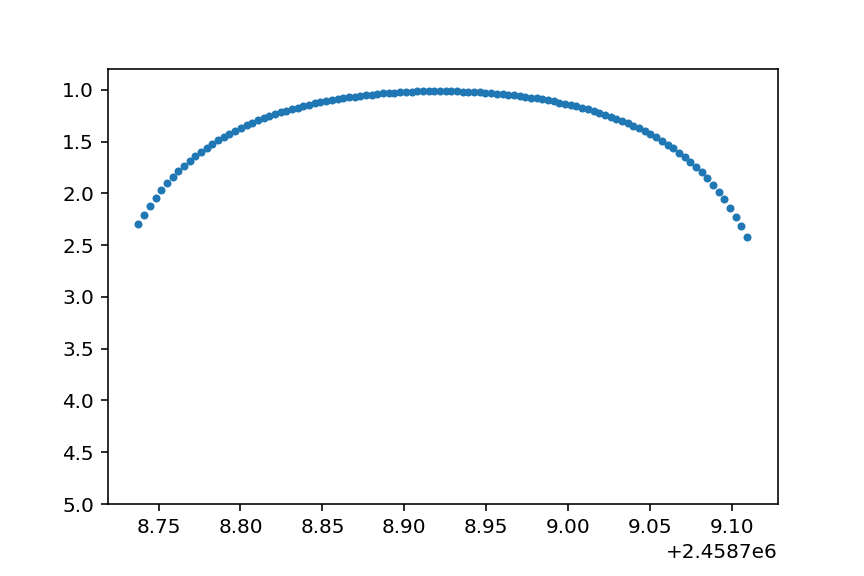

(5, 0.8)

In [235]:
plt.plot(time.jd[index], am[index],'.')
# plt.plot(np.linspace(*time.jd[[0,-1]],1000),fct(np.linspace(*time.jd[[0,-1]],1000)))
# plt.vlines()
plt.ylim(5, 0.8)

In [ ]:
phase_curve_zero

